In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

#data = pd.read_csv("imdb-actors-actresses-movies.tsv", sep="\t")
data = pd.read_csv("prova.tsv", sep="\t")
actors = data.get("Actor")
actors.drop_duplicates(inplace = True)
actors.reset_index(drop = True, inplace = True)
id_actor_dict = actors.to_dict()
print(id_actor_dict)
actor_id_dict = {v: k for k, v in id_actor_dict.items()}
movies = data.get("Movie")
movies.drop_duplicates(inplace = True)
movies.reset_index(drop = True, inplace = True)
movies.index += len(actors)
id_movie_dict = movies.to_dict()
print(id_movie_dict)
movie_id_dict = {v: k for k, v in id_movie_dict.items()}

{0: 'Bryning, John', 1: 'Brynjarsson, Reynir Gar?ar', 2: 'Brynjarsson, Steinarr', 3: 'Brynjolfsson, Ingvar', 4: 'Brynjulfsen, Erik', 5: 'Brynjulfsen, Jan Olav'}
{6: 'Rembrandt (1936)', 7: 'The Amazing Dr. Clitterhouse (1947) (TV)', 8: 'The Rose Without a Thorn (1947) (TV)', 9: 'Hrafninn fl?gur (1984)', 10: 'Br?t?l M?rk (2013)', 11: 'Nj?lssaga (2003) (TV)', 12: 'Varg Veum - Bitre blomster (2007)', 13: 'S?lvmunn (1981)'}


[(0, {'actor': 'Bryning, John', 'bipartite': 0}), (1, {'actor': 'Brynjarsson, Reynir Gar?ar', 'bipartite': 0}), (2, {'actor': 'Brynjarsson, Steinarr', 'bipartite': 0}), (3, {'actor': 'Brynjolfsson, Ingvar', 'bipartite': 0}), (4, {'actor': 'Brynjulfsen, Erik', 'bipartite': 0}), (5, {'actor': 'Brynjulfsen, Jan Olav', 'bipartite': 0}), (6, {'movie': 'Rembrandt (1936)', 'year': 1936, 'bipartite': 1}), (7, {'movie': 'The Amazing Dr. Clitterhouse (1947) (TV)', 'year': 1947, 'bipartite': 1}), (8, {'movie': 'The Rose Without a Thorn (1947) (TV)', 'year': 1947, 'bipartite': 1}), (9, {'movie': 'Hrafninn fl?gur (1984)', 'year': 1984, 'bipartite': 1}), (10, {'movie': 'Br?t?l M?rk (2013)', 'year': 2013, 'bipartite': 1}), (11, {'movie': 'Nj?lssaga (2003) (TV)', 'year': 2003, 'bipartite': 1}), (12, {'movie': 'Varg Veum - Bitre blomster (2007)', 'year': 2007, 'bipartite': 1}), (13, {'movie': 'S?lvmunn (1981)', 'year': 1981, 'bipartite': 1})]


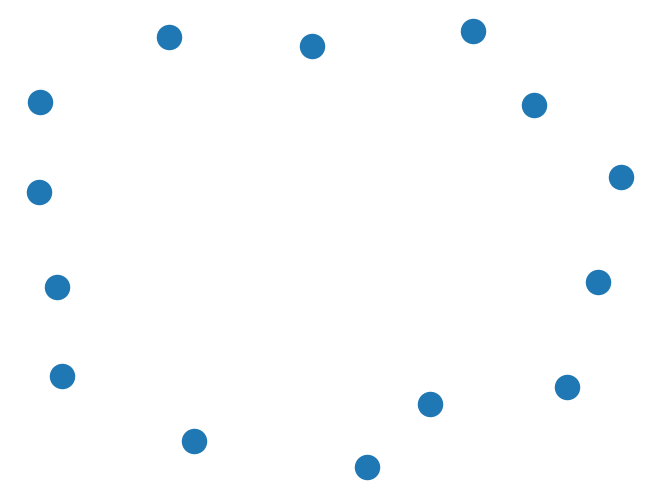

In [12]:
G = nx.Graph()

#se voglio che i nodi siano degli interi ed ognuno ha un attributo "actor" -> meglio
#G.add_nodes_from([(list(id_actor_dict.keys())[i], {"actor":id_actor_dict[i]}) for i in range(6)])
G.add_nodes_from([(id, {"actor": a, "bipartite": 0}) for id, a in id_actor_dict.items()])

#se voglio che i nodi siano delle tuple (id, actor) -> peggio
#G.add_nodes_from(id_actor_dict.items())

#G.add_nodes_from(id_movie_dict, movie=id_movie_dict[next(i for i in range(len(actors), len(actors)+len(movies)))], bipartite=1)
G.add_nodes_from([(id, {"movie": m, "year": int(m[m.index("(")+1:m.index("(")+5]), "bipartite": 1}) for id, m in id_movie_dict.items()])
print(G.nodes.data())
nx.draw(G)

# cella per prove

In [6]:
diz = {0: "a (2000)", 1: "b (2004)"}
i = diz[0].index("(")
diz[0][i:i+6]


'(2000)'